# Feature Matching

Extracts defining key features from input image(using corner, edge and contour detection), then using a distance calculation and finds all matches in a secondary imag(**no need** to have an **exact copy** of the target image).

Check out the link for a 7-series article for feature matching:
https://medium.com/data-breach/introduction-to-feature-detection-and-matching-65e27179885d


Here, 3 methods will be implemented:
- Brute-Force matching with ORB
- Brute-Force matching with SIFT Descriptors and Ratio Test
- FLANN based matcher

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

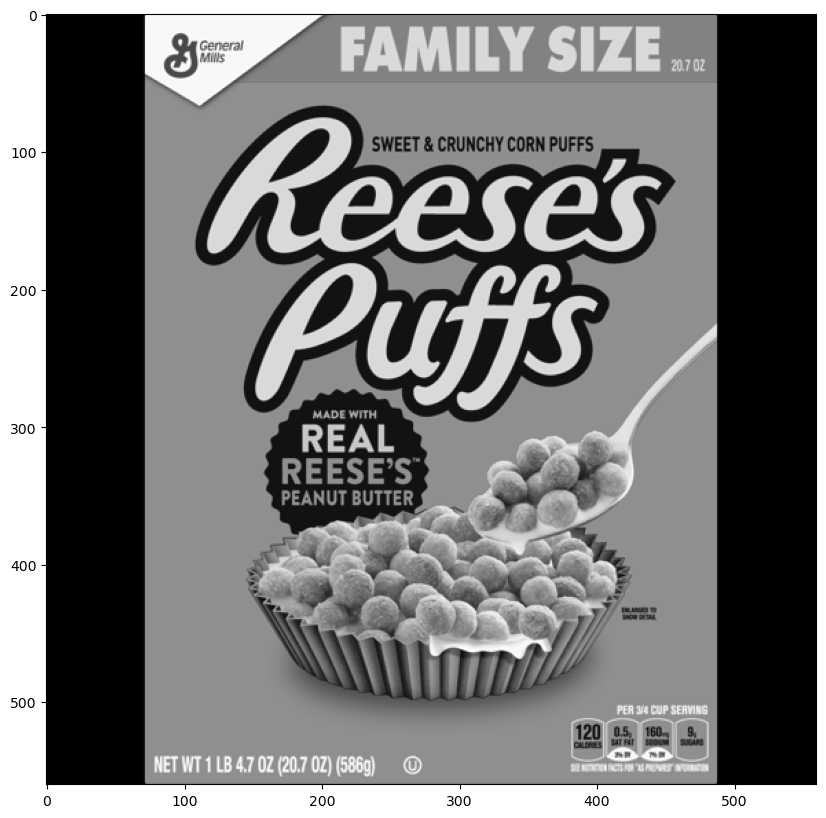

In [3]:
reeses = cv2.imread('../DATA/reeses_puffs.png',0) 
display(reeses)

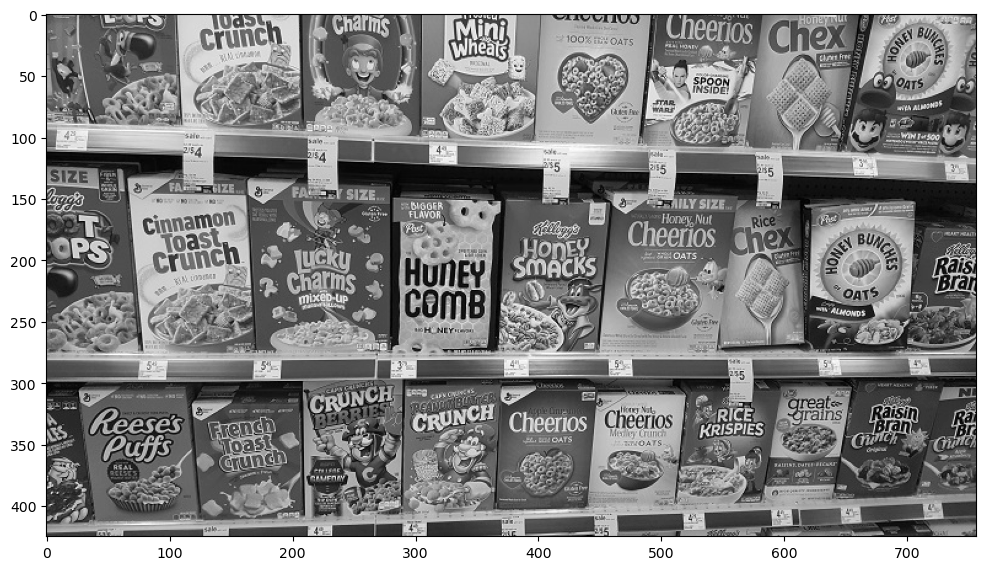

In [4]:
cereals = cv2.imread('../DATA/many_cereals.jpg',0) 
display(cereals)

--------
### Brute Force Detection with ORB Descriptors

In [18]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(reeses,None)
kp2, des2 = orb.detectAndCompute(cereals,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 25 matches.
reeses_matches = cv2.drawMatches(reeses,kp1,cereals,kp2,matches[:25],None,flags=0)

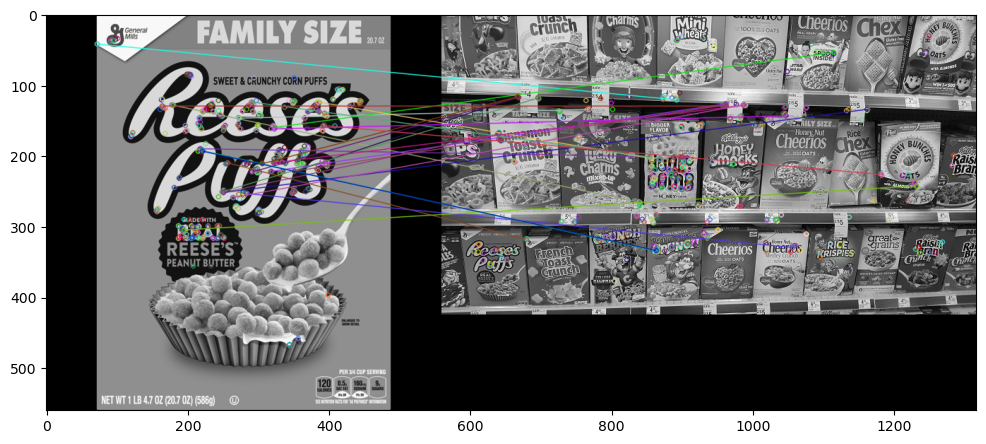

In [19]:
display(reeses_matches)

It does not work specially if your image does not really look like the target image. 

---

### Brute-Force Matching with SIFT Descriptors and Ratio Test

In [58]:
# Create SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
# Finds the k best matches for each descriptor from a query set
matches = bf.knnMatch(queryDescriptors=des1,trainDescriptors=des2, k=2)

# Apply ratio test
# Check if the first k match for the first descriptor is relatively close to each other, so these K in that particular row is probably a good match
# Less distance == better match
# Ratio if match1 < 75% match2, then discriptor was a good match, let's keep it. 
good = []
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

# cv2.drawMatchesKnn expects list of lists as matches.
sift_matches = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,good,None,flags=0)

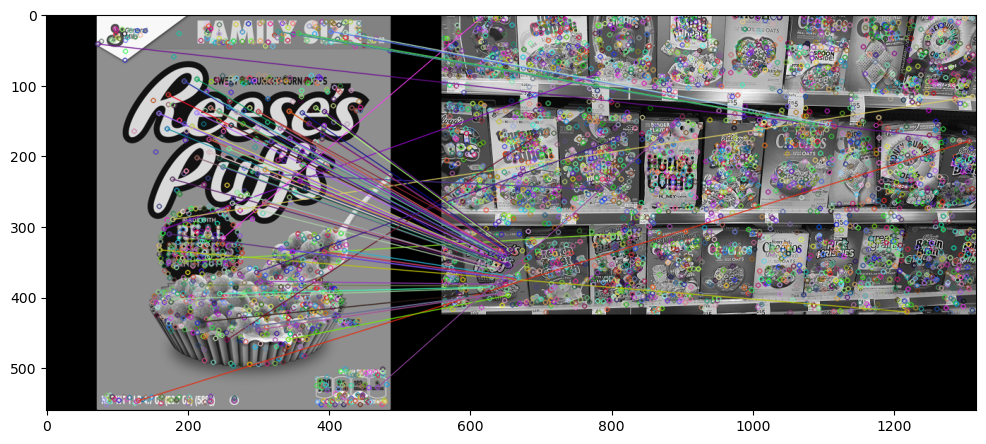

In [59]:
display(sift_matches)

---

### FLANN based Matcher

Matches **much faster** than brut-force matcher, but finds **general good matches** not necesserily the best.

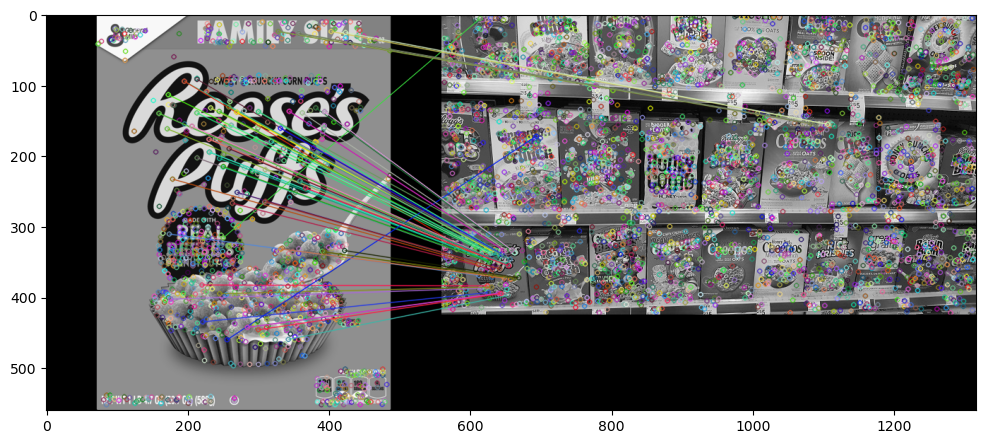

In [60]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []

# ratio test
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        
        good.append([match1])


flann_matches = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,good,None,flags=0)

display(flann_matches)

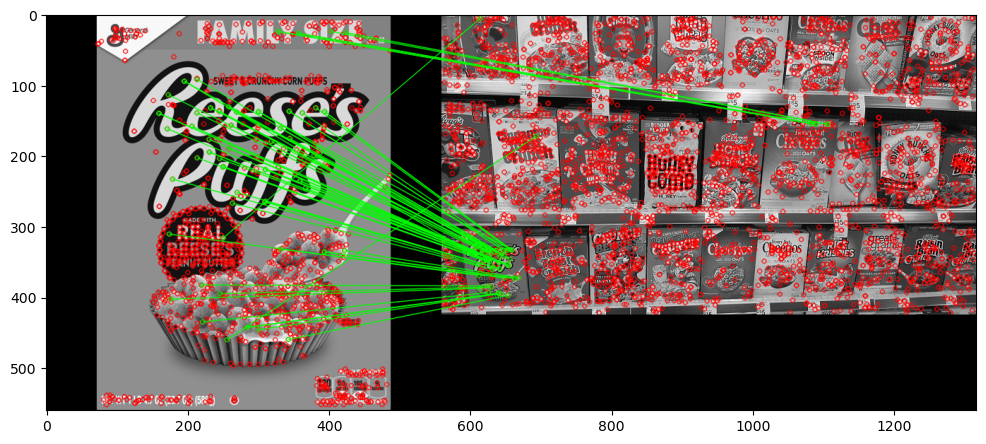

In [62]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesmask = [[0,0] for i in range(len(matches))]

# ratio test
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        matchesmask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesmask,
                   flags = 0)

flann_matches = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,matches,None,**draw_params)

display(flann_matches)